In [1]:
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import torch

# Importing libraries
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

BASE_PATH = 'drive/MyDrive/NLP_project/'
# BASE_PATH = './'
if not os.path.exists(BASE_PATH):
    raise ValueError('path does not exist')

In [4]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


# Define Base Model

In [6]:
class MyBaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.accuracy_train_history = []
        self.accuracy_test_history = []
        self.loss_train_history = []
        self.loss_test_history = []
        self.train_time = 0

    def save(self, path):
        torch.save(self, path)

    @staticmethod
    def load(path) -> nn.Module|None:
        model = None
        if os.path.exists(path):
            print(f'Loading from disc: {path}')
            model = torch.load(path, weights_only=False)
            model.eval()
        else:
            print('Model not found!')
        return model

# Implement functions

- accuracy
- train
- validation
- top level function for training
- plot

In [7]:
def accuracy(pred, y):
    correct = (pred.argmax(dim=1) == y.argmax(dim=1)).type(torch.int8).sum().item()
    return correct / y.shape[0] # average

In [8]:
def train(model, x, y, loss_fn, optimizer):
    model.train()

    # Loop over batches
    for i in range(x.shape[0]):
        # Forward pass and loss calculation
        pred = model(x[i])
        loss = loss_fn(pred, y[i])

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [9]:
def validation(model, x, y, loss_fn):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        pred = model(x)
        loss = loss_fn(pred, y).item()
    return pred, loss

In [10]:
def top_level_func_training(model,
                            x_train,
                            y_train,
                            x_test,
                            y_test,
                            loss_fn,
                            optimizer,
                            MODEL_PATH,
                            number_epochs=0,
                            patience=10,
                            save=True):
    # Initialize Variables for EarlyStopping
    best_loss = float('inf')
    best_model_weights = copy.deepcopy(model.state_dict())

    start_time = time.time()
    # Training Loop with Early Stopping:
    for epoch in tqdm(range(number_epochs)):
        # Train
        train(model, x_train, y_train, loss_fn, optimizer)

        # Validation
        val_pred, val_loss = validation(model, x_test, y_test, loss_fn)
        train_pred, train_loss = validation(model, x_train, y_train, loss_fn)

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here
            patience = 10  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                print('Early stopping...')
                break

        # Save accuracy and loss on test
        model.accuracy_test_history.append(accuracy(val_pred, y_test))
        model.loss_test_history.append(val_loss)

        # Save accuracy and loss on train
        model.accuracy_train_history.append(accuracy(train_pred, y_train))
        model.loss_train_history.append(train_loss)

    end_time = time.time()
    model.train_time += (end_time - start_time)
    # Load the best model weights then save on disc
    model.load_state_dict(best_model_weights)
    if save:
        model.save(MODEL_PATH)

In [11]:
def plot(model):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(model.accuracy_train_history)), np.array(model.accuracy_train_history) * 100, label='Train')
    plt.plot(np.arange(len(model.accuracy_test_history)), np.array(model.accuracy_test_history) * 100, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy (batch size=100)')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(model.loss_train_history)), np.array(model.loss_train_history), label='Train')
    plt.plot(np.arange(len(model.loss_test_history)), np.array(model.loss_test_history), label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss (batch size=100)')
    plt.legend()
    plt.grid()
    plt.show()
    print(f'best loss on test dataset = {model.loss_test_history[-1]:.2f}')
    print(f'best accuracy on test dataset = {model.accuracy_test_history[-1] * 100}%')
    print(f'train time = {model.train_time}')

# Define neural network model

In [17]:
class NeuralNetwork1(MyBaseModel):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(21844, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 150),
            nn.ReLU(),
            nn.Linear(150, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# Prepare data



In [13]:
x_train_tensor = torch.load(BASE_PATH + 'tensors/x_train_tensor.pt', weights_only=False)
y_train_tensor = torch.load(BASE_PATH + 'tensors/y_train_tensor.pt', weights_only=False)
x_test_tensor = torch.load(BASE_PATH + 'tensors/x_test_tensor.pt', weights_only=False)
y_test_tensor = torch.load(BASE_PATH + 'tensors/y_test_tensor.pt', weights_only=False)

## Create Mini-batch

In [14]:
print(x_train_tensor.shape)
print(y_train_tensor.shape)

torch.Size([130000, 21844])
torch.Size([130000, 10])


In [15]:
batch_size = 100
x_train_batch = x_train_tensor.reshape(-1, batch_size, x_train_tensor.shape[1])
y_train_batch = y_train_tensor.reshape(-1, batch_size, y_train_tensor.shape[1])

In [16]:
print(x_train_batch.shape)
print(y_train_batch.shape)

torch.Size([1300, 100, 21844])
torch.Size([1300, 100, 10])


## Move to GPU

In [18]:
x_train_batch = x_train_batch.to(device)
y_train_batch = y_train_batch.to(device)
x_test_tensor = x_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Train the model

## Model 1

In [26]:
MODEL_PATH = BASE_PATH + 'models/nlp_model1.pt'
model = NeuralNetwork1.load(MODEL_PATH)
if not model:
    model = NeuralNetwork1()
model = model.to(device)
model = model.type(torch.float16)

Model not found!


In [29]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
top_level_func_training(model,
                        x_train_batch,
                        y_train_batch,
                        x_test_tensor,
                        y_test_tensor,
                        loss_fn,
                        optimizer,
                        MODEL_PATH,
                        number_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

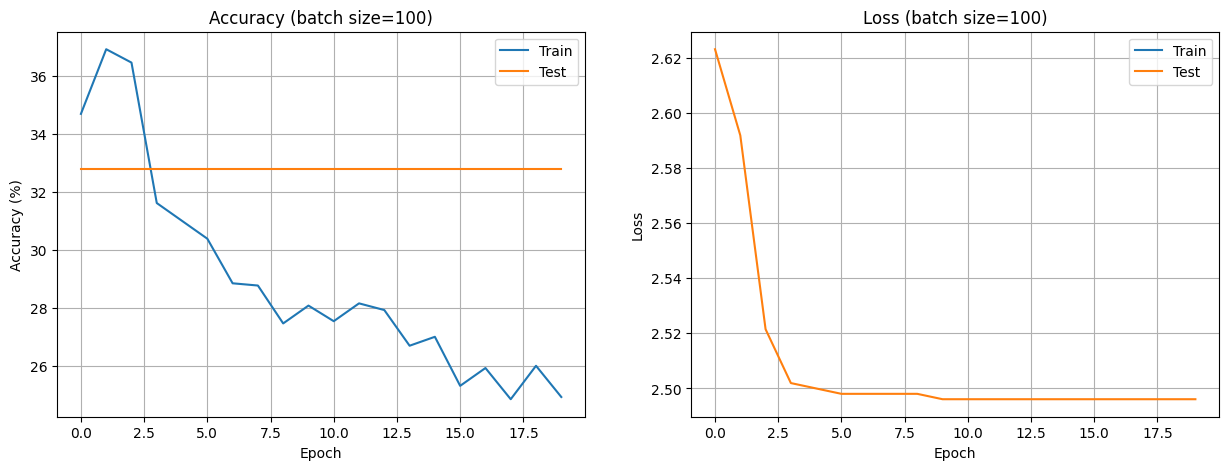

best loss on test dataset = 2.50
best accuracy on test dataset = 32.80628668812725%
train time = 74.82926726341248


In [30]:
plot(model)